In [1]:
# 全国第四类故障预测

In [2]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.sparse import coo_matrix, bmat
from scipy.cluster.hierarchy import fclusterdata
%matplotlib inline

# Data Explore

In [3]:
data = pd.read_csv('/usr/local/hadoop/src/code/dianbiao/data/all_4.csv', dtype={0:object, 'ORG':object, 'SPEC_CODE':object, 'MANUFACTURER':object,
                                                  'FAULT_MONTH':int, 'INST_MONTH':object, 'FAULT_QUARTER':object, 
                                                  'FAULT_TYPE': object,'SYNC_ORG_NO':object,'ORG_NO':object
                                              
                                                 }, encoding='utf-8')

#preview the zhejiang_4 data
data.head()

/home/hadoop/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,EQUIP_ID,FAULT_TYPE,SYNC_ORG_NO,ORG_NO,SPEC_CODE,COMM_MODE,MANUFACTURER,FAULT_DATE1,INST_DATE1,FAULT_MONTH,INST_MONTH,month,FAULT_TYPE_1
0,120000000096143.0,408,11101,1140610,106,11,48,2015-08-10 00:00:00,2012-05-24 00:00:00,8,5,39.0,4
1,8000000042733340.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-06 00:00:00,8,3,17.0,4
2,8000000042733830.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-06 00:00:00,8,3,17.0,4
3,8000000042733390.0,408,11101,1140610,106,12,965,2015-08-21 00:00:00,2014-03-05 00:00:00,8,3,17.0,4
4,8000000042733460.0,408,11101,1140610,106,12,965,2015-08-24 00:00:00,2014-03-07 00:00:00,8,3,17.0,4


# feature preprocessing

In [4]:
data.drop([data.columns[0]], axis=1, inplace=True)

In [5]:
data['FAULT_TYPE'].value_counts()

409    138923
404     83185
411     83173
407     79011
408     60459
401     37631
402     29698
410     18601
405      7637
406      5895
403      5817
Name: FAULT_TYPE, dtype: int64

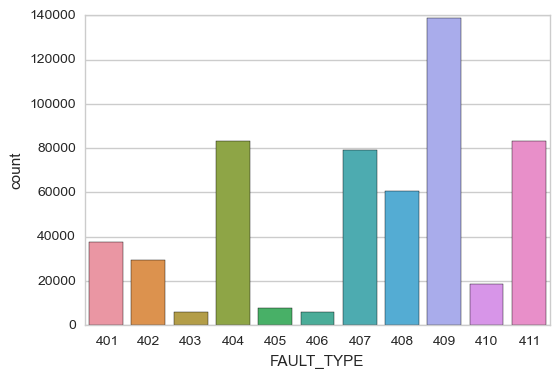

In [6]:
fig, axis0 = plt.subplots(1, 1)
sns.countplot(x='FAULT_TYPE', data=data, ax=axis0)

* 此图为全国第四类故障类型数量统计图
* 从故障类型柱状图可以看出故障类型数据不平衡，402-406较少，407-411较多

## SYNC_ORG_NO

count     550030
unique        15
top        33101
freq      190996
Name: SYNC_ORG_NO, dtype: object


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


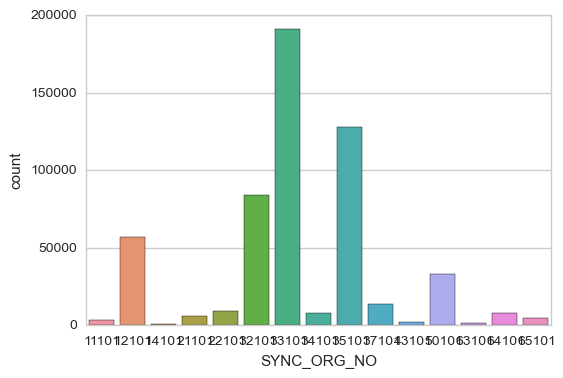

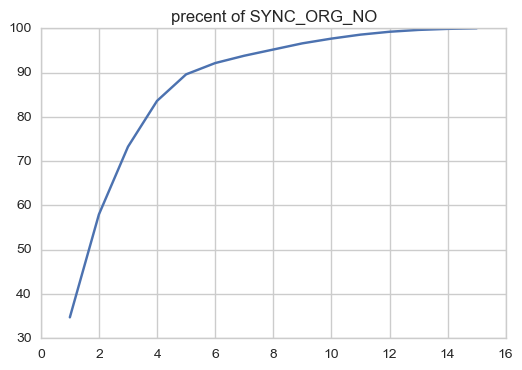

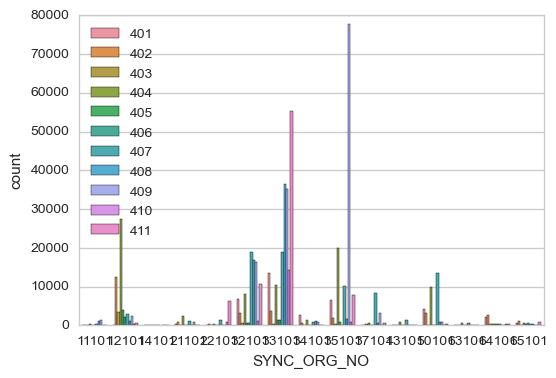

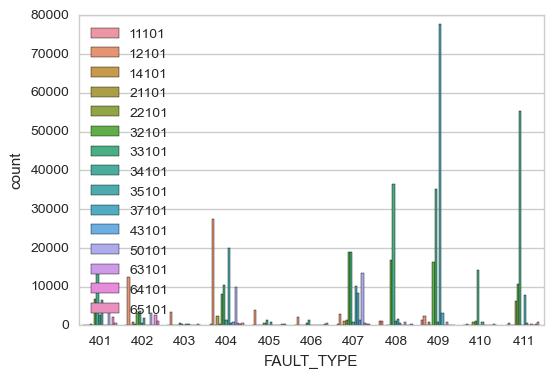

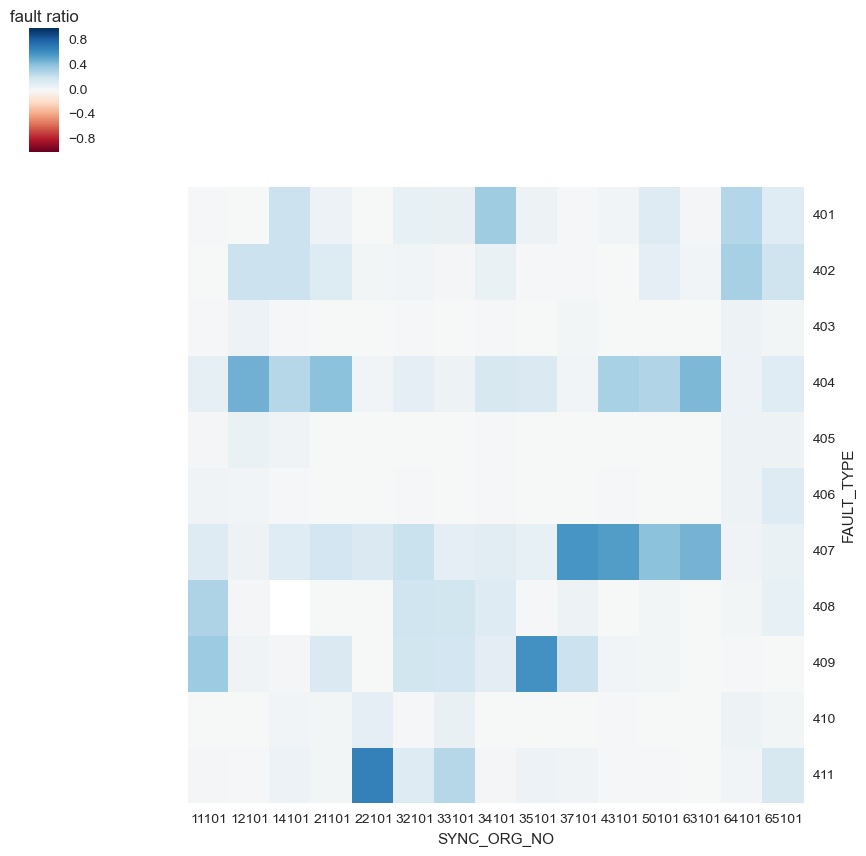

In [7]:
#ORG
print data['SYNC_ORG_NO'].describe()
#plot
def plot_fun(name_fea, name_fault, fontsize=None):
    
    fig, axis1 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, data=data, ax = axis1)

    fig, axis2 = plt.subplots(1, 1)
    c = data[name_fea].value_counts()
    s = c.cumsum()/c.sum()
    axis2.plot(np.arange(s.shape[0])+1, s.values*100)
    axis2.set_title('precent of %s'%name_fea)

    fig, axis3 = plt.subplots(1, 1)
    sns.countplot(x=name_fea, hue=name_fault, data=data, ax=axis3)
    plt.legend(loc = 2)

    fig, axis4 = plt.subplots(1, 1)
    sns.countplot(x=name_fault, hue=name_fea, data=data, ax=axis4)
    plt.legend(loc = 2, fontsize=fontsize)

    #calculate similar score
    from scipy.cluster.hierarchy import dendrogram, linkage    
    #clustermap

    fault_num1 = data.groupby([name_fault, name_fea])[data.columns[0]].count().unstack()

    ratio = fault_num1 / fault_num1.sum()  

    g1 = sns.clustermap(ratio, 
                        cmap=plt.get_cmap('RdBu'),
                        vmax=1,
                        vmin=-1,
                        linewidth=0,
                        figsize=(10, 10),
                        row_cluster=False,
                        col_cluster=False
                    )
    plt.title('fault ratio')
#聚类函数
def cluster_encoding(name):
    global data
    fault_num = data.groupby(['FAULT_TYPE', name])[data.columns[0]].count().unstack()
    MAN_ratio = fault_num / fault_num.sum()
    MAN_ratio_T = MAN_ratio.T

    clusters = fclusterdata(np.array(MAN_ratio_T), 1)
    print clusters.shape
    clusters_mapping = {label:idx for label,idx in zip(MAN_ratio.columns, clusters)}
    data[name] = data[name].map(clusters_mapping)
#plot
plot_fun('SYNC_ORG_NO', 'FAULT_TYPE')
#get_dummies
SYNC_ORG_dummies = coo_matrix(pd.get_dummies(data['SYNC_ORG_NO']))

(596,)
(550030, 20)


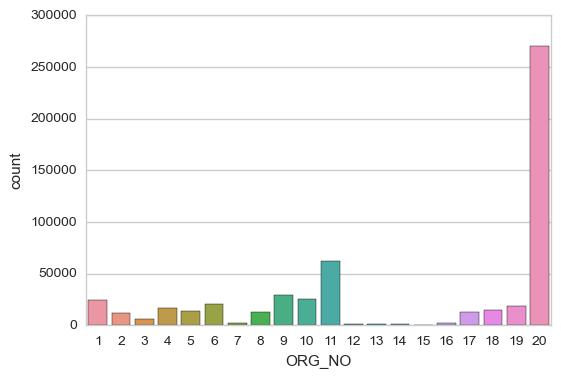

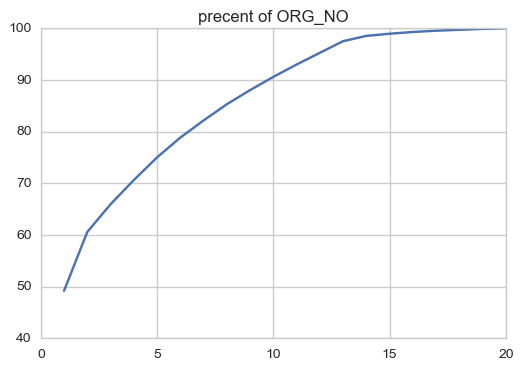

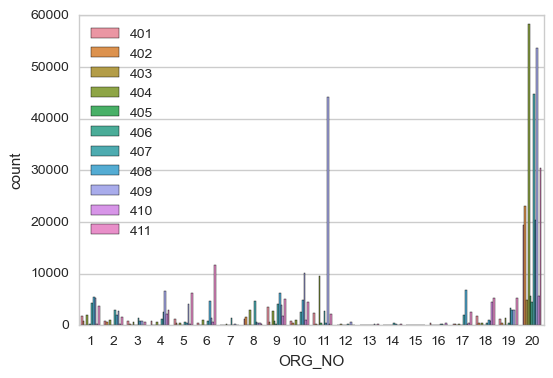

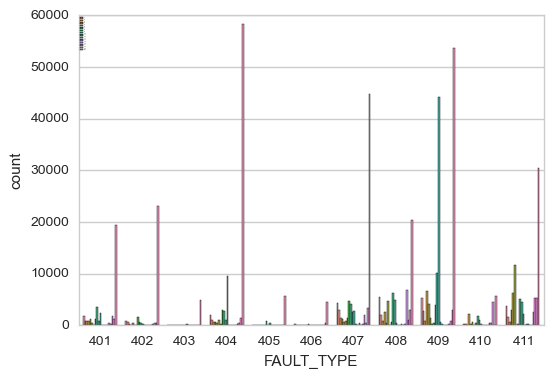

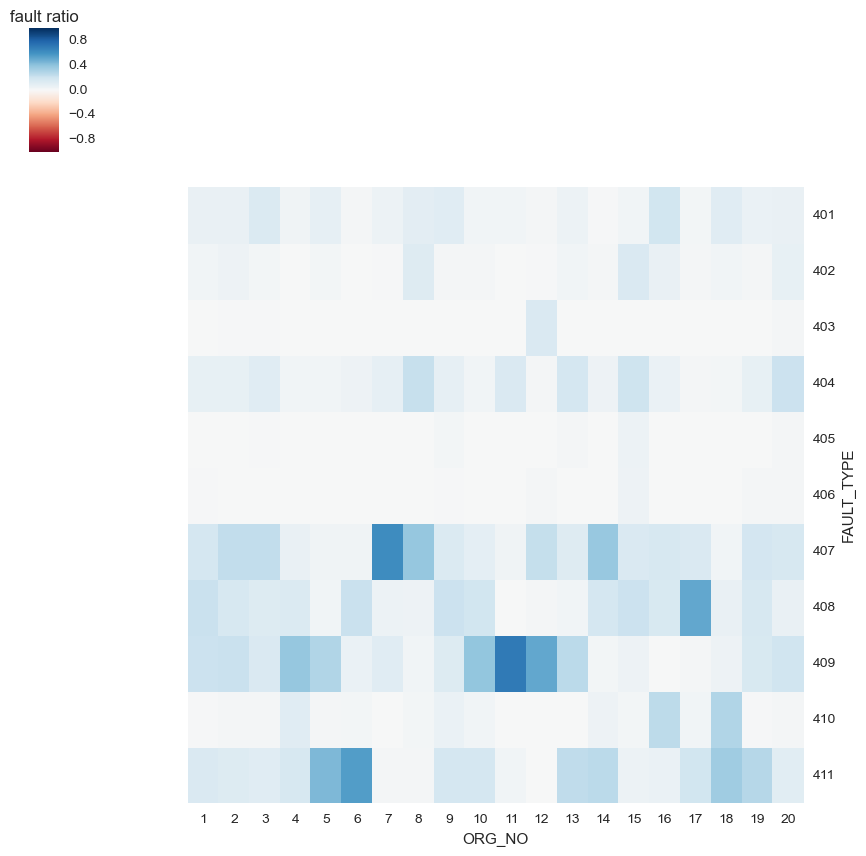

In [8]:
#ORG
data['ORG_NO'].describe()
#plot

#get_dummies
ORG_freq = data['ORG_NO'].value_counts().index[data['ORG_NO'].value_counts().values<100]
data['ORG_NO'] = data['ORG_NO'].replace(ORG_freq.values, 0)
cluster_encoding('ORG_NO')
plot_fun('ORG_NO', 'FAULT_TYPE',fontsize=1)
ORG_dummies = coo_matrix(pd.get_dummies(data['ORG_NO']))# 转化为稀疏矩阵
print ORG_dummies.shape

## ORG故障类型统计
- 各个地区的故障数量不同，前8个到95%
- 从ORG与FAULT_TYPE统计图可以看出，不同地区的故障类型分布有所不同，所以认为ORG对于FAULT_TYPE类型的识别是有用的。
- 故障类型分布图显示了每个地区的故障类型占比
- 有几个地区故障类型数据较少[33101,33407,33411]，对于故障类型识别用处不大，删除
- 对属性做了二元变换处理

## SPEC_CODE

In [9]:
#SPEC_CODE
data['SPEC_CODE'].describe()

count     550030
unique        35
top          102
freq      259992
Name: SPEC_CODE, dtype: object

In [10]:
data['SPEC_CODE'].value_counts()

102    259992
100     96813
101     68483
104     51859
118     25823
108     11281
103      6217
121      6153
112      5015
106      3497
115      3101
113      2892
131      2560
129      1631
119      1157
125       849
116       748
122       411
109       312
123       295
130       222
107       204
136       151
138        89
           75
135        58
126        51
139        31
111        26
127        13
134         8
141         7
105         3
132         2
140         1
Name: SPEC_CODE, dtype: int64

[u'138' u' ' u'135' u'126' u'139' u'111' u'127' u'134' u'141' u'105' u'132'
 u'140']


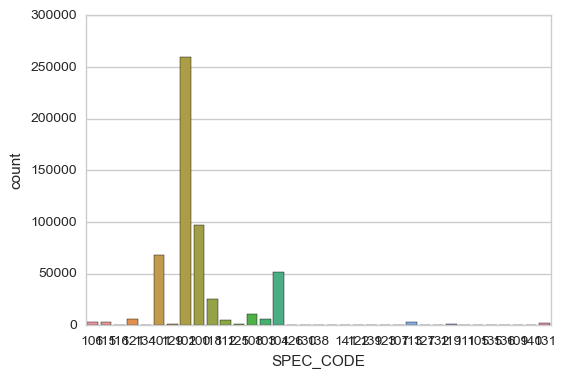

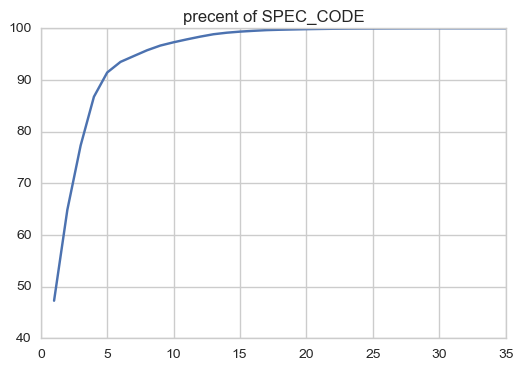

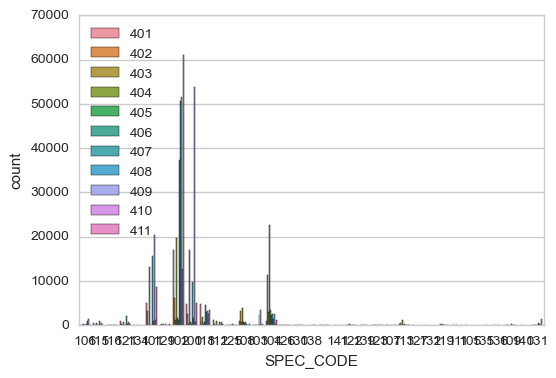

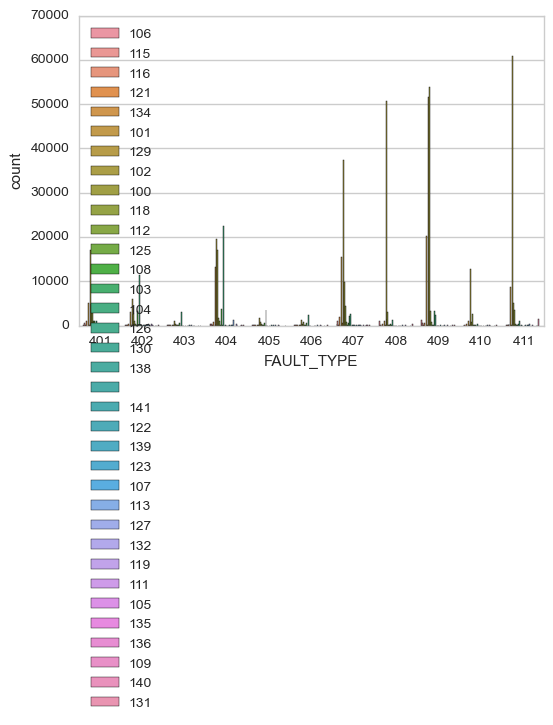

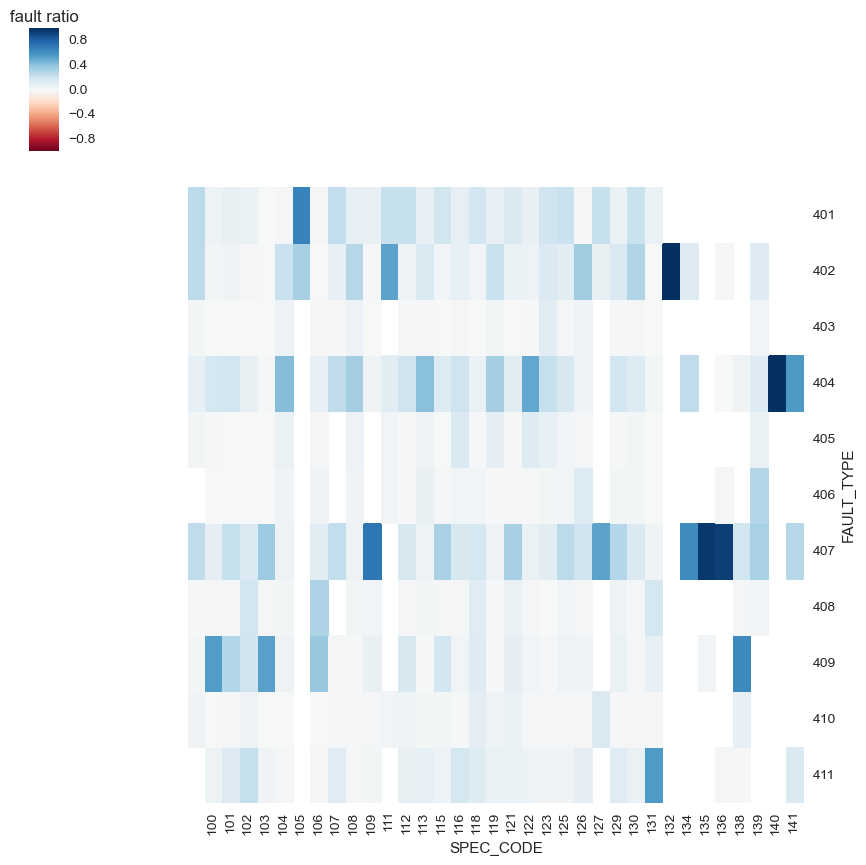

In [11]:
plot_fun('SPEC_CODE', 'FAULT_TYPE')
spec_freq = data['SPEC_CODE'].value_counts().index[data['SPEC_CODE'].value_counts().values<100]
#spec_mapping = {label:idx for label,idx in zip(spec_freq, np.zeros(len(spec_freq)))}
print spec_freq.values

In [12]:
data['SPEC_CODE'].value_counts()
data['SPEC_CODE'] = data['SPEC_CODE'].replace(spec_freq.values, 0)
print data['SPEC_CODE'].value_counts()
SPEC_dummies = coo_matrix(pd.get_dummies(data['SPEC_CODE']))

102    259992
100     96813
101     68483
104     51859
118     25823
108     11281
103      6217
121      6153
112      5015
106      3497
115      3101
113      2892
131      2560
129      1631
119      1157
125       849
116       748
122       411
0         364
109       312
123       295
130       222
107       204
136       151
Name: SPEC_CODE, dtype: int64


## SPEC_CODE故障类型统计
- SPEC_CODE故障类型同样呈现分布不均匀状态
- 前两类设备类型数据达到98%
- 每种故障类型的SPEC_CODE基本相似
- 故障类型分布图显示了每种SPEC_CODE故障类型占比
- 删除极少出现的SPEC_CODE故障类型
- 对属性进行二元变换

# MANUFACTURER

In [13]:
data['MANUFACTURER'].value_counts()

845      32859
965      27525
268      27350
1118     27033
136      26862
10127    22698
1043     22062
417      17677
578      17432
10010    16900
1133     15098
924      13733
10007    13284
10001    12131
25       10548
826      10487
262       9426
719       9314
686       9074
1086      8603
306       8438
21        7847
954       7832
10021     7634
10009     7459
588       7399
243       7360
446       6882
926       6847
1064      6715
         ...  
317        131
102        124
10532      102
400         88
235         81
1108        79
834         77
10492       70
1181        44
906         40
10756       36
1111        33
10002       27
10783       20
10267        9
204          7
10149        6
10428        6
10542        6
10741        3
90           2
10186        2
10154        1
10008        1
10787        1
10159        1
1155         1
10545        1
10066        1
10014        1
Name: MANUFACTURER, dtype: int64

(99,)
36


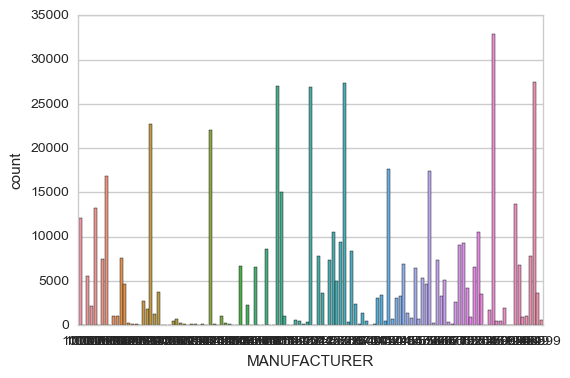

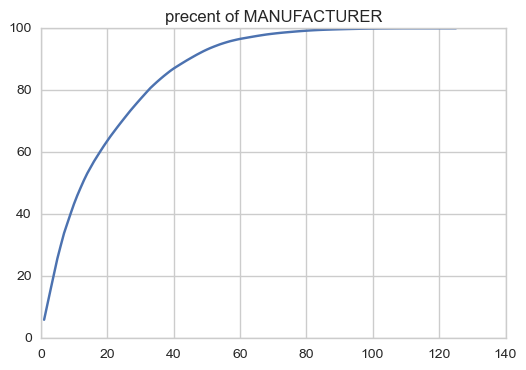

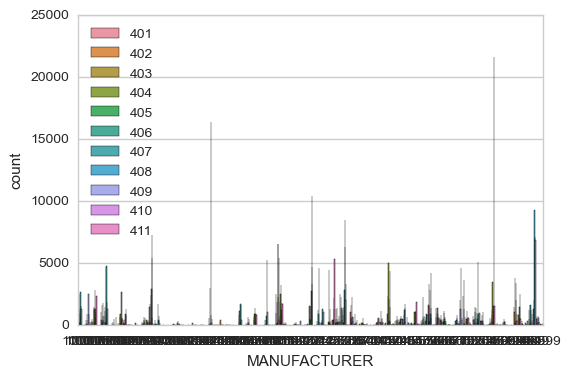

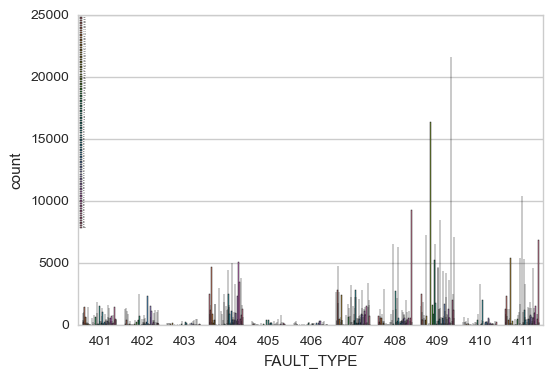

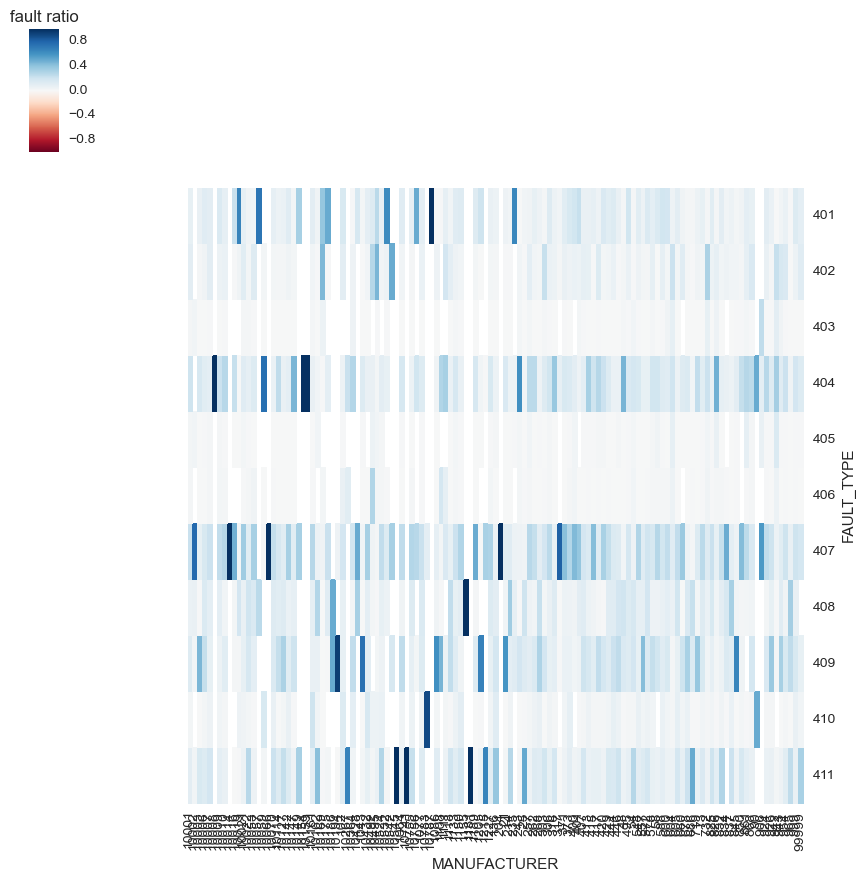

In [14]:
plot_fun('MANUFACTURER', 'FAULT_TYPE', fontsize=1)
spec_freq = data['MANUFACTURER'].value_counts().index[data['MANUFACTURER'].value_counts().values<100]
data['MANUFACTURER'] = data['MANUFACTURER'].replace(spec_freq.values, 0)
cluster_encoding('MANUFACTURER')
print len(data['MANUFACTURER'].value_counts())
MAN_dummies = coo_matrix(pd.get_dummies(data['MANUFACTURER']))

## MANUFACTURER故障类型统计
- MANUFACTURER故障类型同样呈现分布不均匀状态,浙江省一共有80家供应商，电表数前30家占90%
- 前两类故障类型数据达到98%
- 每种故障类型的供应商分布不同
- 故障类型分布图显示了每种供应商故障类型占比，应用分层聚类方法将具有相似故障类型分布的供应商进行合并
- 对属性进行二元变换

# MONTH

/home/hadoop/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/hadoop/.local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


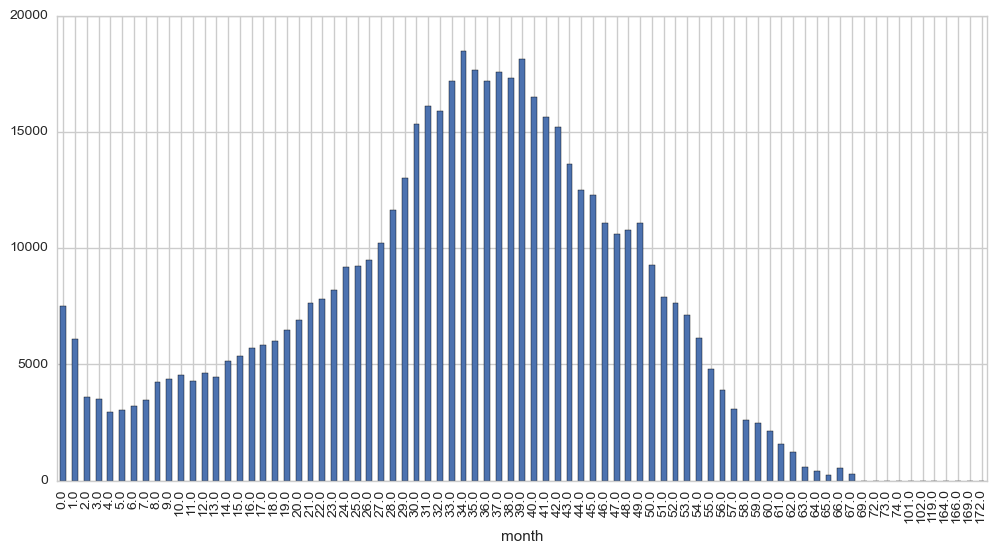

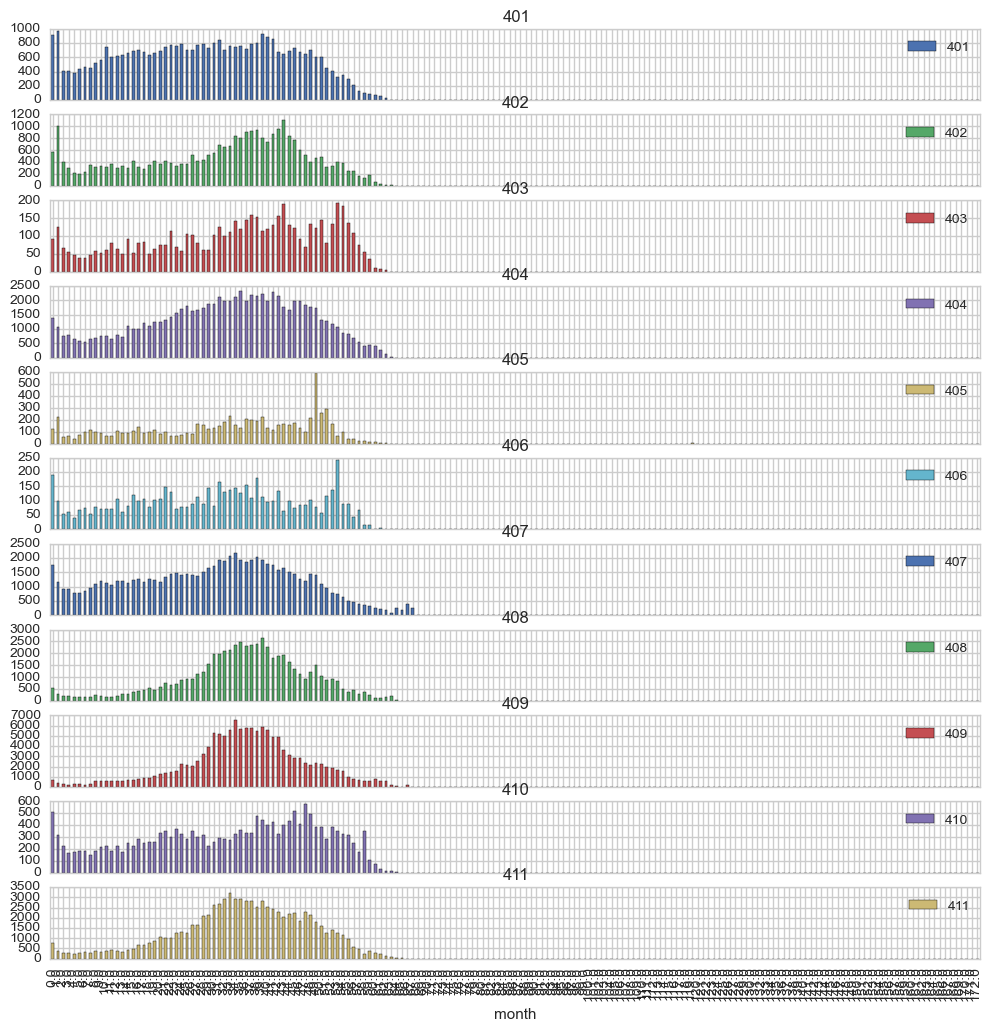

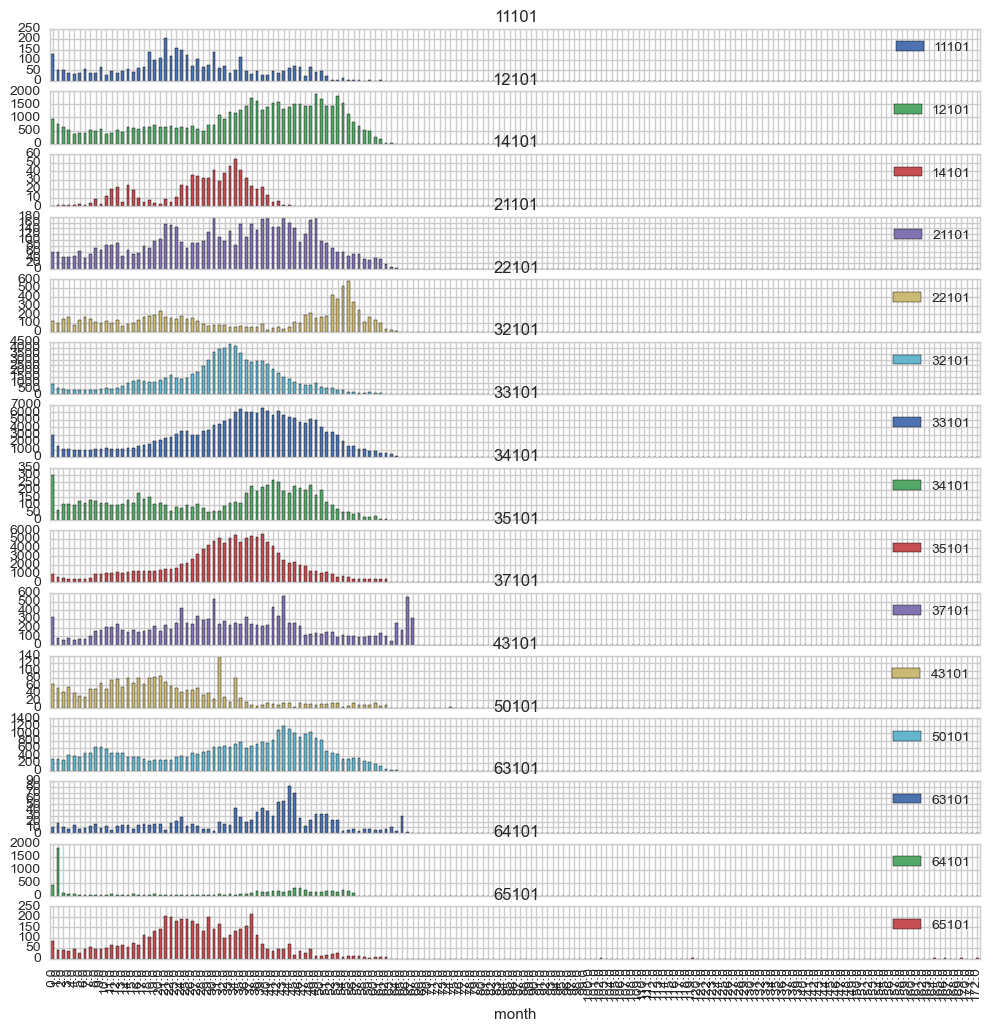

In [15]:
# use month distribution
c1 = data.groupby(['month']).size()
c1.plot(kind='bar', figsize=(12, 6))

c2 = data.groupby(['month', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c2.plot(kind='bar', figsize=(12, 12), subplots=True)

c3 = data.groupby(['month', 'SYNC_ORG_NO']).size().unstack().reindex(index=np.arange(data.month.min(), data.month.max()+1)).fillna(0)
c3.plot(kind='bar', figsize=(12, 12), subplots=True)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['month'] = min_max_scaler.fit_transform(data['month'])

## 使用寿命-故障类型统计
- 对浙江省故障电表使用寿命进行了统计，可看出其分布基本为正态分布，符合客观规律。
- 使用寿命-故障类型图显示了每种故障类型的使用寿命分布情况，基本为正态分布，但是其分布参数有所不同，可以用来作为分类特征。
- 使用寿命-供电所分布图，不同供电所的使用寿命分布有区别，可以得出供电所对电表使用寿命有影响。

## FAULT_MONTH

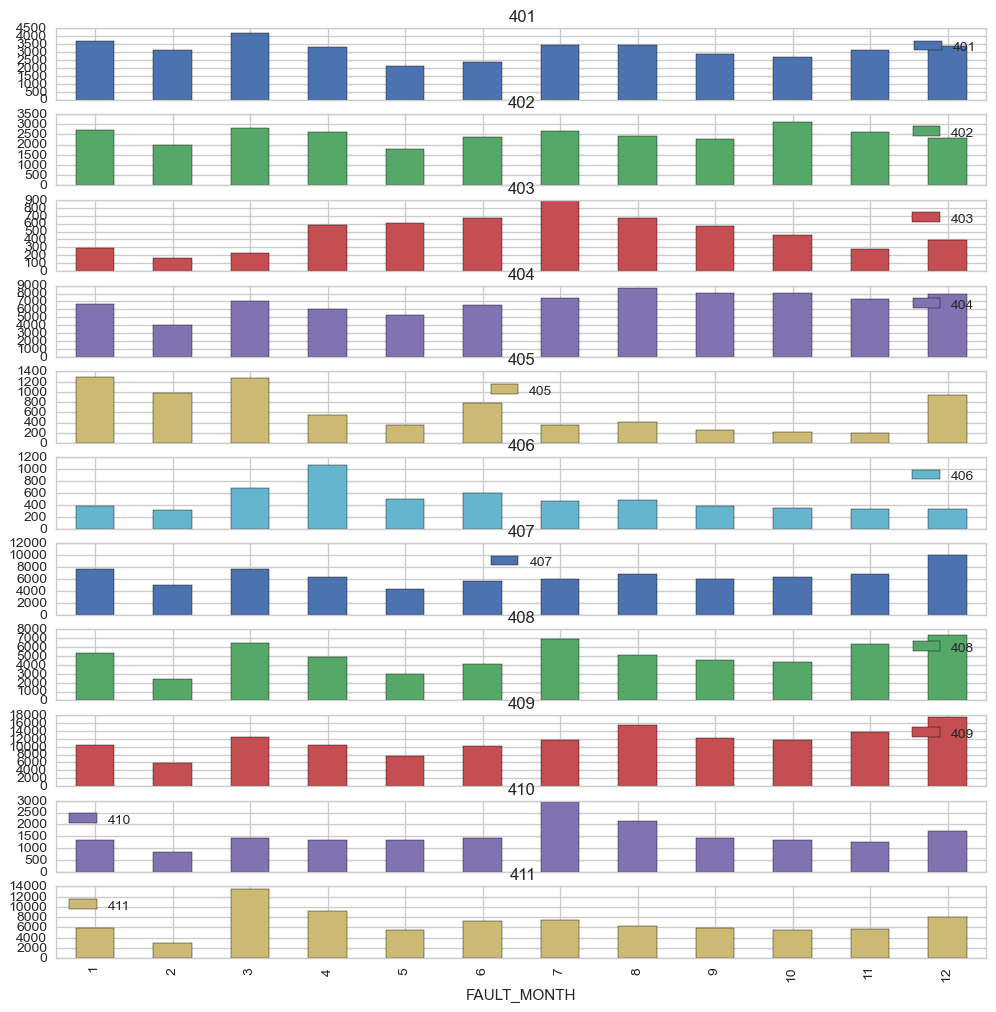

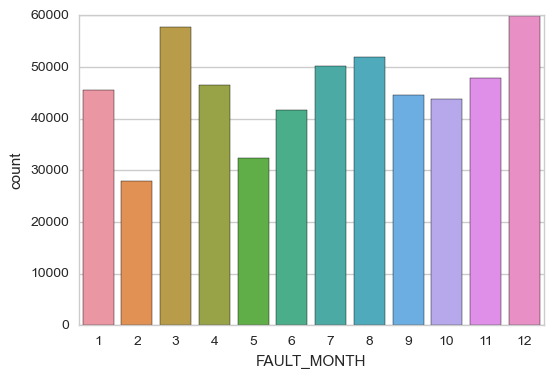

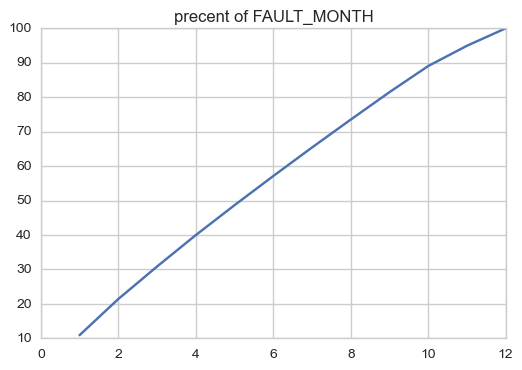

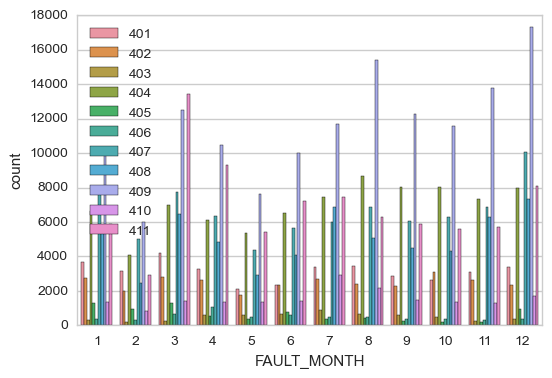

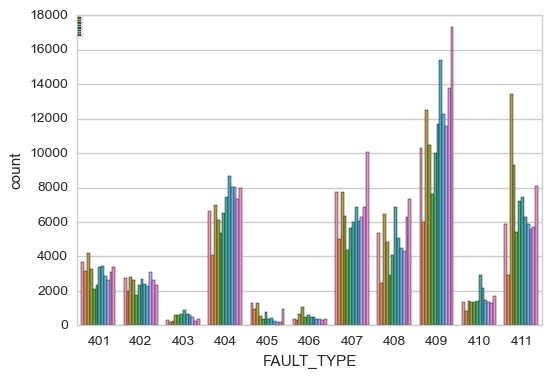

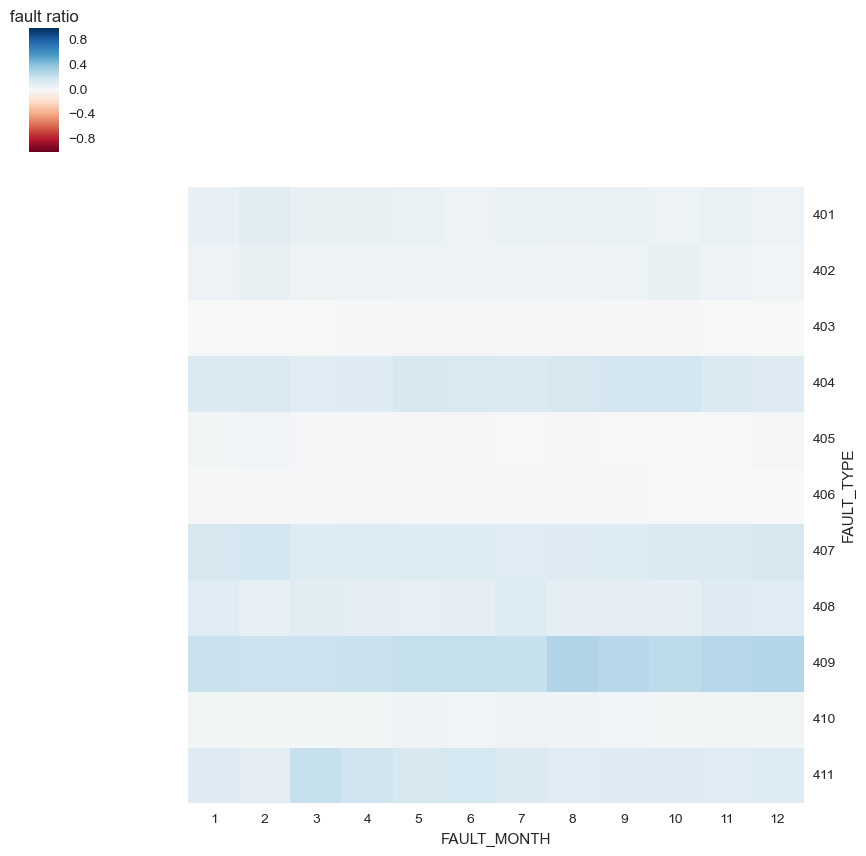

In [16]:
data['FAULT_MONTH'] = pd.Categorical(data['FAULT_MONTH'], ordered=True)

m1 = data.groupby(['FAULT_MONTH', 'FAULT_TYPE']).size().unstack().reindex(index=np.arange(data.FAULT_MONTH.min(), data.FAULT_MONTH.max()+1)).fillna(0)
m1.plot(kind='bar', figsize=(12, 12), subplots=True)
plot_fun('FAULT_MONTH', 'FAULT_TYPE', fontsize=1)
'''
fault_num4 = data.groupby(['FAULT_TYPE', 'FAULT_MONTH'])[data.columns[0]].count().unstack()

FAUMON_ratio = fault_num4 / fault_num4.sum()
FAUMON_ratio_T = FAUMON_ratio.T

clusters = fclusterdata(np.array(FAUMON_ratio_T), 0.70)
clusters = clusters+20
print clusters
clusters_mapping = {label:idx for label,idx in zip(FAUMON_ratio.columns, clusters)}
data['FAULT_MONTH'] = data['FAULT_MONTH'].map(clusters_mapping)
'''
#get_dummies
FAUMON_dummies = coo_matrix(pd.get_dummies(data['FAULT_MONTH']))

data['INST_MONTH'] = pd.Categorical(data['INST_MONTH'], ordered=True)
INSMON_dummies = coo_matrix(pd.get_dummies(data['INST_MONTH']))
#data = data.join(FAUMON_dummies)
#data.drop(['FAULT_MONTH'], axis=1, inplace=True)
#del fault_num4, FAUMON_ratio, FAUMON_ratio_T, clusters, clusters_mapping, FAUMON_dummies

## 故障月份-故障类型统计
- 故障月份-故障数量统计表显示了不同月份故障数量的分布，分布不是很均匀
- 故障月份-故障类型图显示了每月的故障类型分布情况，每个月的故障类型占比基本相似，是比较弱的分类特征。
- 故障月份-故障类型分布图，不同月份故障类型占比基本相似。

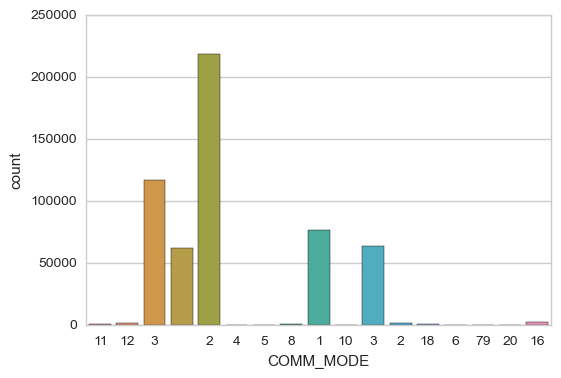

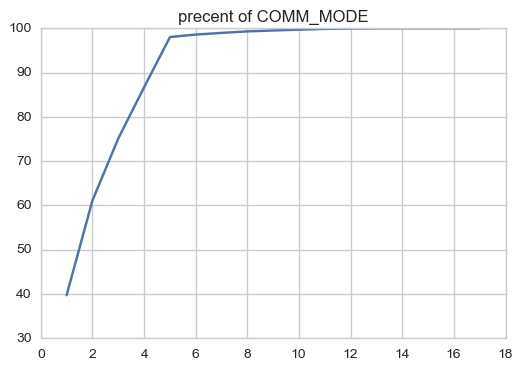

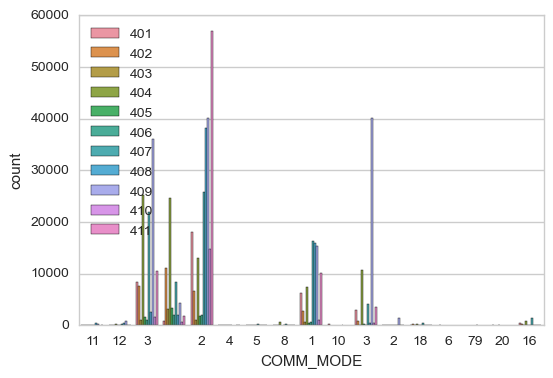

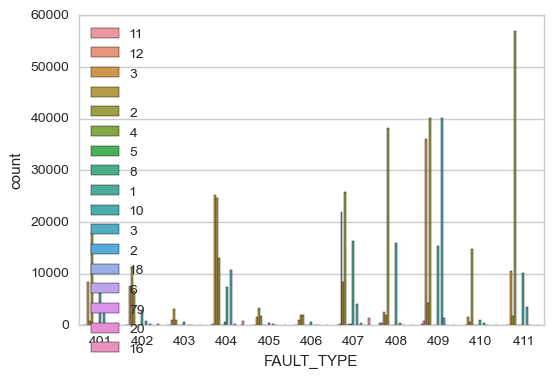

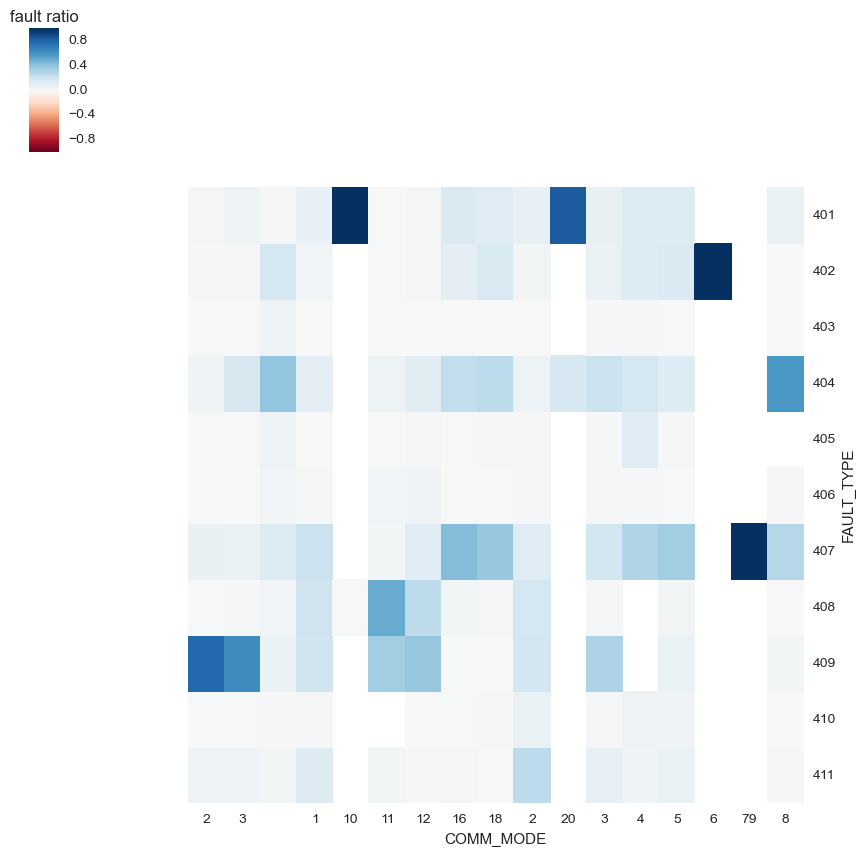

In [17]:
data['COMM_MODE'].value_counts()
plot_fun('COMM_MODE', 'FAULT_TYPE')
COMM_freq = data['COMM_MODE'].value_counts().index[data['COMM_MODE'].value_counts().values<100]
data['COMM_MODE'] = data['COMM_MODE'].replace(COMM_freq.values, 0)
COMM_dummies = coo_matrix(pd.get_dummies(data['COMM_MODE']))# 转化为稀疏矩阵

In [18]:
data.columns

Index([u'FAULT_TYPE', u'SYNC_ORG_NO', u'ORG_NO', u'SPEC_CODE', u'COMM_MODE',
       u'MANUFACTURER', u'FAULT_DATE1', u'INST_DATE1', u'FAULT_MONTH',
       u'INST_MONTH', u'month', u'FAULT_TYPE_1'],
      dtype='object')

In [19]:
#整合数据
data = data.join(pd.DataFrame(bmat([[SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies]]).toarray()))
data.drop(['FAULT_MONTH','SYNC_ORG_NO', 'ORG_NO', 'SPEC_CODE', 'MANUFACTURER', 'FAULT_TYPE_1', 'FAULT_DATE1', 
           'INST_DATE1', 'COMM_MODE', 'INST_MONTH'], axis=1, inplace=True)

del SYNC_ORG_dummies, ORG_dummies, SPEC_dummies, MAN_dummies, FAUMON_dummies, INSMON_dummies, COMM_dummies

## 机器学习算法故障预测

In [20]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
from scipy.sparse import csc_matrix
data_X = data.drop(['FAULT_TYPE'], axis=1)
data_y = data['FAULT_TYPE']
#encode label
le = preprocessing.LabelEncoder()
data_y = le.fit_transform(data_y)
data_X1 = csc_matrix(data_X.ix[:200000]) 
data_X2 = csc_matrix(data_X.ix[200001:400000])
data_X3 = csc_matrix(data_X.ix[400001:])
data_X4 = bmat([[data_X1], [data_X2], [data_X3]], format='coo')
del data_X1, data_X2, data_X3
train, test, train_y, test_y = train_test_split(data_X4, data_y, test_size=0.33, random_state=27)

# XGBoost

In [22]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

TRAIN = True  #是否训练
CV = False
#split train set and test set
dtrain = xgb.DMatrix(train, train_y)
dtest = xgb.DMatrix(test)

clf = xgb.XGBClassifier(
    learning_rate = 0.2,
    n_estimators = 660,
    max_depth = 8,
    colsample_bytree = 0.8,
    subsample = 0.9,
    objective = 'multi:softmax',
    min_child_weight = 1,
    gamma = 2,
    seed = 27
    )

param = clf.get_xgb_params()
param['num_class'] = 11
if CV:
    cvresult = xgb.cv(param, dtrain, num_boost_round=2000, nfold=3, stratified=True,
                  metrics='merror', early_stopping_rounds=10,verbose_eval=True)
    clf.set_params(n_estimators=cvresult.shape[0])   #set n_estimators as cv rounds
if TRAIN:
    clf.fit(train, train_y, eval_metric='merror')
else:
    clf = pickle.load(open("zhejiang_4_all.pkl", "rb"))
        

ypred_xgb = clf.predict(test)
ypred_xgb = le.inverse_transform(ypred_xgb)
test_y_xgb = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_xgb, ypred_xgb))
print(confusion_matrix(test_y_xgb, ypred_xgb))
pickle.dump(clf, open("zhejiang_4_all_jiaoliu.pkl", "wb"))

             precision    recall  f1-score   support

        401       0.45      0.34      0.38     12447
        402       0.66      0.54      0.60      9901
        403       0.47      0.28      0.35      1899
        404       0.64      0.52      0.58     27239
        405       0.66      0.44      0.53      2509
        406       0.49      0.26      0.34      1922
        407       0.49      0.61      0.54     25894
        408       0.52      0.49      0.50     20028
        409       0.68      0.79      0.73     46013
        410       0.56      0.44      0.49      6227
        411       0.59      0.63      0.61     27431

avg / total       0.59      0.59      0.59    181510

[[ 4203   403    19  1082    16    40  3113   623  1475   415  1058]
 [  564  5382    50  1097   102    86  1165   267   553   160   475]
 [   82   238   533   373    24    62   325    57   136    12    57]
 [  859   751   142 14231   160   110  4264   921  4469   154  1178]
 [   92   160    41   290  1110 

* 召回率(Recall)=  系统检索到的相关文件 / 系统所有相关的文件总数
* 准确率(Precision) =  系统检索到的相关文件 / 系统所有检索到的文件总数
* f1 = 2*Recall*Precision / (Recall+Precision)

In [ ]:
param_test1 = {'max_depth':range(5,12,2), 'min_child_weight':range(1,7,2)}
gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy',n_jobs=-1,cv=2, verbose=True)
gsearch1.fit(train, train_y)
print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 2 folds for each of 12 candidates, totalling 24 fits


In [ ]:
data['FAULT_TYPE'].value_counts()

# SGDClassifier
使用随机梯度下降线性分类器

对于线性不可分情况，使用rbf核将数据映射到高维空间中

In [ ]:
from sklearn.kernel_approximation import RBFSampler, Nystroem

USE_RBF = False   #True：RBFSampler, False:Nystroem
if USE_RBF:
    rbf_feature = RBFSampler(gamma=1, random_state=1)
    train_SGD = rbf_feature.fit_transform(train)
    test_SGD = rbf_feature.transform(test)
else:
    Nys_feature = Nystroem(gamma=1, random_state=1)
    train_SGD = Nys_feature.fit_transform(train)
    test_SGD = Nys_feature.transform(test)
        

In [ ]:
from sklearn.linear_model import SGDClassifier

USE_GridSearch = False
clf = SGDClassifier(loss='modified_huber', alpha=0.01, n_iter=100, class_weight="balanced", random_state=27)
if USE_GridSearch:
    param_test1 = {'loss':['hinge', 'log','modified_huber', 'squared_hinge', 'perceptron'], 'alpha':[0.1, 0.01, 0.01, 0.0001]}
    gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy', n_jobs=-1,cv=2, verbose=True)
    gsearch1.fit(train_SGD, train_y)
    print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
    clf = gsearch1
else:
    clf.fit(train_SGD, train_y)
ypred_sgd = clf.predict(test_SGD)
ypred_sgd = le.inverse_transform(ypred_sgd)
test_y_sgd = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_sgd, ypred_sgd))
print(confusion_matrix(test_y_sgd, ypred_sgd))
pickle.dump(clf, open("zhejiang_4_SGD.pkl", "wb"))

## KNN

In [ ]:
from sklearn import neighbors

USE_GridSearch = False
n_neighbors = 50
 
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
if USE_GridSearch:
    param_test1 = {'n_neighbors':range(20,60,10), 'weights':['uniform', 'distance']}
    gsearch1 = GridSearchCV(estimator=clf, param_grid = param_test1, scoring='accuracy', n_jobs=-1,cv=2, verbose=True)
    gsearch1.fit(train, train_y)
    print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
    clf = gsearch1
else:
    clf.fit(train, train_y)
ypred_knn = clf.predict(test)
ypred_knn = le.inverse_transform(ypred_knn)
test_y_knn = le.inverse_transform(test_y)
#print model report:
print(classification_report(test_y_knn, ypred_knn))
print(confusion_matrix(test_y_knn, ypred_knn))
pickle.dump(clf, open("zhejiang_4_KNN.pkl", "wb"))

* XGBoost算法使用决策树作为弱分类器，如果训练数据可分的情况下将会一直拟合数据知道训练准确率100%，可以证明数据不可分
* SGDClassifier是针对数据量较大的线性分类器，当线性分类无效时，使用rbf将数据映射到高维空间中，再采用线性分类其进行分类，效果不佳
* 使用KNN算法
## 下一步计划

1. 获取供电所位置坐标信息，将其用于统计基于省、市单位的故障类型分布以及使用寿命热力分布图
2. 调研具有更加有区分度的数据，是否能再现有数据的基础上进行一些变换？
3. 利用挂装量计算未故障电表故障数据，进行电表是否发生故障预测
4. 电表使用寿命作为目标，进行电表使用寿命预测